# Metody jądrowe (kernel methods)

In [1]:
import numpy as np
import pandas as pd

## Duży zbiór danych do klasyfikacji

Użyjemy najpierw bioinformatycznego zbioru danych [Cod-RNA](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#cod-rna). Pochodzi on z artykułu ([link do wersji Open Access](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-173)):

> Uzilov, Andrew V., Joshua M. Keegan, and David H. Mathews. *"Detection of non-coding RNAs on the basis of predicted secondary structure formation free energy change."* BMC bioinformatics 7.1 (2006): 1-30. [link](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-173)

[Centralny dogmat biologii molekularnej (central dogma of molecular biology)](https://en.wikipedia.org/wiki/Central_dogma_of_molecular_biology) mówi, że przepływ informacji genetycznej przebiega z DNA przez RNA do białek. Innymi słowy, DNA zapisuje informację biologiczną, którą potem koduje RNA, z którego są syntezowane białka.

W praktyce nie każde DNA i RNA koduje informacje. Kodujące DNA to zaledwie ok. 1-2% ludzkiego genomu, a reszta pełni różne role, głównie regulacyjne. W szczególności [niekodujące RNA (non-coding RNA, ncRNA)](https://en.wikipedia.org/wiki/Non-coding_RNA) pełni wiele różnych zadań, na przykład:
- budują rybosomy odpowiadające za syntezę białek ([rRNA](https://en.wikipedia.org/wiki/Ribosomal_RNA))
- transportują informację genetyczną ([tRNA](https://en.wikipedia.org/wiki/Transfer_RNA))
- regulują ekspresję genów ([lncRNA](https://en.wikipedia.org/wiki/Long_non-coding_RNA))

Nie są znane wszystkie funkcje niekodującego RNA, więc jest to aktywne pole badań. Najpierw trzeba jednak sprawdzić, czy dane RNA w ogóle jest kodujące, czy nie. Taka klasyfikacja jest nieoczywista, i też stanowi pole badań w bioinformatyce. Niektóre hipotezy wskazują, że struktura drugorzędowa RNA ma tutaj znacznie.

Struktura pierwszorzędowa kwasu nukleinowego (DNA lub RNA) to po prostu liniowa sekwencja nukleotydów, np. ACCUUGCAUC. Struktura drugorzędowa oznacza ułożenie par nukleotydów (np. G-C, A-U) jednego lub dwóch łańcuchów.  Dla DNA to typowo podwójna helisa, natomiast RNA tworzy już bardzo bogate i złożone struktury. Przewidywanie struktury wyższego rzędu to typowe zadanie ML w bioinformatyce, bo sprawdzanie tego eksperymentalnie jest bardzo drogie.

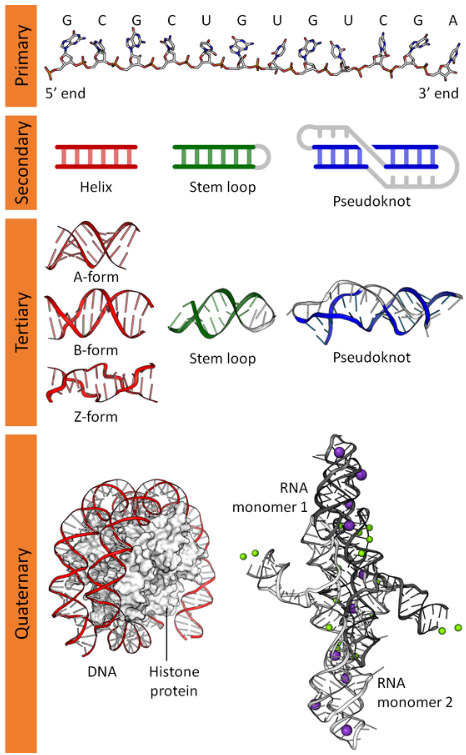

Przykładem algorytmu przewidującego strukturę drugorzędową jest [Dynalign](https://www.sciencedirect.com/science/article/abs/pii/S0022283601953513). Opiera się on na obserwacji, że niektóre struktury drugorzędowe RNA są bardziej stabilne od innych. Struktury o niższej energii są, zgodnie z zasadami termodynamiki, wolniejsze, a zatem stabilniejsze i bardziej prawdopodobne. Algorytm ten dodatkowo realizuje **dopasowanie sekwencji (sequence alignment)**, czyli takie "przyłożenie" do siebie sekwencji RNA, żeby jak najwięcej par pasowało do siebie. Wejściem do niego są 2 sekwencje RNA, a wyjściem ilość wolnej energii w optymalnej strukturze drugorzędowej RNA - im mniejsza, tym stabilniejsza jest struktura.

Artykuł, z którego pochodzi nasz zbiór danych, zaproponował zastosowanie ML do klasyfikacji, czy dwie sekwencje RNA stanowią niekodujące RNA (ncRNA), czy też nie. Zbiór treningowy zbudowano z blisko 60 tysięcy par sekwencji RNA pochodzących z sekwencjonowania genomu bakterii *Escherichia coli* oraz *Salmonella enterica serovar Typhi (Salmonella typhi)*. Klasą pozytywną jest niekodujące RNA (5S rRNA albo tRNA), a negatywną losowo przemieszane nukleotydy z prawdziwej pary (istnieją do tego algorytmy tzw. sequence shuffling). Klasy są w stosunku 1:2, więc mamy klasyfikację lekko niezbalansowaną. Analogicznie stworzono zbiór testowy o wielkości nieco ponad 270 tysięcy par.

Jako cech użyto:
- wartości z algorytmu Dynalign
- długości krótszej sekwencji
- częstotliwości zasad azotowych A/U/C w sekwencji 1 (3 cechy)
- częstotliwości zasad azotowych A/U/C w sekwencji 2 (3 cechy)

Mamy zatem klasyfikację binarną, umiarkowanie niezbalansowaną, i 8 cech numerycznych. Jako metryk autorzy używają precyzji, czułości, krzywych ROC oraz wartości AUROC.

My dla uproszczenia użyjemy F1-score, czyli średniej harmonicznej precyzji (precision) i czułości (recall). Klasyczny SVM nie potrafi przewidywać prawdopodobieństw, a rozwinięcie, które na to pozwala (tzw. Platt scaling), jest kosztowne i daje raczej niskiej jakości predykcje prawdopodobieństw. Z tego powodu AUROC nie jest dla nich zbyt wygodną metryką.

Oryginalny zbiór jest w formacie `svmlight`, z którego korzystają biblioteki LibSVM i Liblinear. Są one standardowymi implementacjami SVMów. Sam ten format danych jest jednak tekstowy i zajmuje bardzo dużo miejsca, dlatego w tym repozytorium jest już przetworzony do formatu Parquet. Wczytamy teraz dane.

Później trzeba dokonać normalizacji cech, tak jak zawsze w SVMach. Tak jak autorzy, wykonamy skalowanie min-max do zakresu [-1, 1].

**Zadanie 1 (0.5 punktu)**

1. Wczytaj dane treningowe z plików `cod_rna_train.parquet` oraz `cod_rna_test.parquet`.
2. Wyodrębnij kolumnę `y` do osobnych zmiennych `y_train` oraz `y_test`.
3. Dokonaj skalowania danych do zakresu [-1, 1], tworząc tablice `X_train_scaled` oraz `X_test_scaled`.
4. Narysuj wykres częstości klas w zbiorze treningowym.

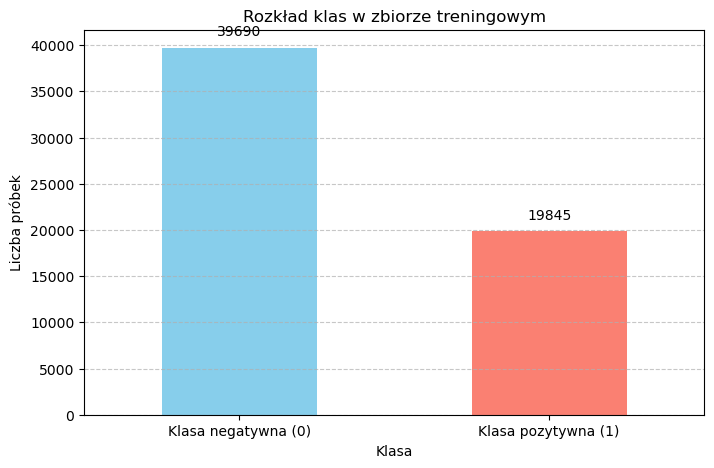

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

train_data = pd.read_parquet('cod_rna_train.parquet')
test_data = pd.read_parquet('cod_rna_test.parquet')

X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

plt.figure(figsize=(8, 5))
y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Rozkład klas w zbiorze treningowym')
plt.xlabel('Klasa')
plt.ylabel('Liczba próbek')
plt.xticks([0, 1], ['Klasa negatywna (0)', 'Klasa pozytywna (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(y_train.value_counts()):
    plt.text(i, count + 1000, str(count), ha='center', va='bottom')

plt.show()

Skoro dane są gotowe, to wytrenujmy nasz pierwszy klasyfikator - liniowy SVM.

W Scikit-learn funkcja kosztu (`loss`) to albo typowy hinge loss, albo squared hinge loss, czyli po prostu podniesiona do kwadratu. Wartość domyślna to `"squared_hinge"` - żeby dostać "typowego" SVMa, trzeba to zmienić. Jest różniczkowalna i mocniej kara duże błędy, ale jest też bardziej podatna na outliery. Dla zainteresowanych: [przystępny tutorial](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-hinge-squared-hinge-loss-with-keras.md) oraz artykuł naukowy:

C.P. Lee, and C.J. Lin. *"A study on L2-loss (squared hinge-loss) multiclass SVM."* Neural computation 25.5 (2013): 1302-1323.

Dodatkowo domyślna liczba iteracji solwera (1000) jest często dość niska, szczególnie przy dużych zbiorach. Zwiększymy to od razu, żeby mieć mniej warningów. Powyżej 10 tysięcy iteracji warningami można się już zazwyczaj nie przejmować.

In [3]:
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC


clf_linear_svc = LinearSVC(loss="hinge", max_iter=10000, random_state=0)
clf_linear_svc.fit(X_train_scaled, y_train)

y_pred = clf_linear_svc.predict(X_test_scaled)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


F1-score: 93.03%


## Liniowy SVM

**Zadanie 2 (0.5 punktu)**

Wytrenuj regresję logistyczną jako nasz **model baseline'owy**. Nasze bardziej złożone modele SVM muszą być od niego lepsze, żeby był w ogóle sens je rozważać.

Użyj regularyzacji L2. Dokonaj tuningu siły regularyzacji (100 wartości) za pomocą 5-krotnej walidacji skrośnej. Jako metryki do tuningu użyj F1-score.

Użyj zbalansowanych wag klas. W razie potrzeby zwiększ maksymalną liczbę iteracji solwera. Może się przydać `n_jobs`. Pamiętaj o ustawieniu `random_state=0`.

Sprawdź wyniki algorytmu na zbiorze testowym.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

param_grid = {
    'C': np.logspace(-4, 4, 100),
    'class_weight': ['balanced']  
}

logreg = LogisticRegression(penalty='l2', max_iter=10000, random_state=0, solver='lbfgs', n_jobs=-1)

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

print("Rozpoczynam tuning regresji logistycznej...")
grid_search.fit(X_train_scaled, y_train)

print("\nNajlepsze parametry:", grid_search.best_params_)
print("Najlepszy F1-score (walidacja):", grid_search.best_score_)

best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X_test_scaled)
test_f1 = f1_score(y_test, y_pred)

print("\nWyniki na zbiorze testowym:")
print(f"F1-score: {100 * test_f1:.2f}%")
print("\nPełny raport klasyfikacji:")
print(classification_report(y_test, y_pred))

Rozpoczynam tuning regresji logistycznej...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Najlepsze parametry: {'C': 7.054802310718645, 'class_weight': 'balanced'}
Najlepszy F1-score (walidacja): 0.9073340044498854

Wyniki na zbiorze testowym:
F1-score: 93.28%

Pełny raport klasyfikacji:
              precision    recall  f1-score   support

        -1.0       0.97      0.96      0.97    181078
         1.0       0.92      0.95      0.93     90539

    accuracy                           0.95    271617
   macro avg       0.95      0.95      0.95    271617
weighted avg       0.96      0.95      0.95    271617



Nasz SVM bez żadnego tuningu jest zasadniczo tak dobry, jak regresja logistyczna z tuningiem - całkiem nieźle. No ale czas teraz na tuning samego SVMa.

Najpierw warto wiedzieć jeszcze parę rzeczy o implementacji użytej w Scikit-learn, korzystającej pod spodem z Liblinear.

Argument `dual` wyznacza, czy skorzystać z postaci primal, czy dual. Jeżeli liczba próbek jest znacznie większa od liczby cech, albo ogółem mamy sporo próbek, to lepiej użyć primal `dual=False`. Niestety, wtedy mamy do dyspozycji tylko funkcję kosztu `squared_hinge`.

SVM jest stricte jednowątkowy (sekwencyjny), więc równoległość można wykorzystać przy tuningu hiperparametrów. Zdecydowanie warto użyć tu `n_jobs=-1`.

**Uwaga:** jako że osobne joby są tworzone jako osobne procesy, to wyłączenie `ConvergenceWarning` jest nietrywialne, a czasem niemożliwe. Sugeruję to po prostu zignorować.

**Zadanie 3 (1 punkt)**

Dokonaj tuningu hiperparametru `C` liniowego SVM. Użyj 5-krotnej walidacji skrośnej, wybierając model o najwyższym F1-score. Użyj zbalansowanych wag klas i funkcji kosztu hinge loss. Pamiętaj o stałym `random_state`.

Zastosuj iteracyjne zagęszczanie siatki. Najpierw sprawdź wartości z zakresu `[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]` i znajdź optymalną wartość `C`. Następnie wedle własnego uznania zagęść siatkę wokół znalezionego optymalnego C. Może się przydać `np.linspace()` albo `list(range())`. Jeżeli w takiej operacji wychodzi optymalne `C` na granicy (najmniejsze albo największe możliwe), to warto sprawdzić większe wartości niż dotychczas rozważane. Powtórz takie działanie 2-3 razy. W praktyce jednak `C` większe niż kilkaset nie ma sensu w kontekście SVMów.

Wypisz ostatecznę znalezioną optymalną wartość odwrotności siły optymalizacji `C`. Sprawdź wynik na zbiorze testowym. Czy udało się przebić baseline?

In [5]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import numpy as np

svm = LinearSVC(loss='hinge', dual=True, class_weight='balanced', random_state=0, max_iter=10000)

C_range = [1e-3, 1e-2, 1e-1, 1, 10, 100]
grid = GridSearchCV(svm, {'C': C_range}, scoring='f1', cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_C = grid.best_params_['C']

if best_C == min(C_range):
    new_C_range = np.geomspace(best_C / 10, best_C * 2, 5)
elif best_C == max(C_range):
    new_C_range = np.geomspace(best_C / 2, best_C * 10, 5)
else:
    new_C_range = np.geomspace(best_C / 3, best_C * 3, 5)

grid = GridSearchCV(svm, {'C': new_C_range}, scoring='f1', cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test_scaled)
test_f1 = f1_score(y_test, y_pred)

print(f"Ostateczne C: {grid.best_params_['C']:.5f}")
print(f"F1-score (test): {100 * test_f1:.2f}%")


C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Ostateczne C: 1000.00000
F1-score (test): 93.29%


C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Jest lepiej o 0.01% od zwyklego liniowego, więc chyba musimy go jeszcze poprawić

Może się to jeszcze uda poprawić - w końcu w artykule autorzy używali kernel SVM, a nie liniowego!

## Kernel SVM

Kernel SVM w Scikit-learn jest implementowany w klasie `SVC`. Wypróbujmy podstawową wersję, bez tuningu hiperparametrów. Przy okazji wiemy, że złożoność kernel SVM to co najmniej $O(n^2)$ - zobaczmy, ile to zajmuje w praktyce.

Warto zawsze ustawić nieco wyższą wartość `cache_size` niż domyślna. Jest to ilość MB na cache'owanie obliczonych wartości kerneli. Warto jednak uważać na zbyt duże wartości:
- wartości ponad 2000 mogą [powodować problemy przez buga w LibSVM](https://github.com/scikit-learn/scikit-learn/issues/8012)
- sama alokacja dużej ilości pamięci (ciągłej!) może zajmować dużo czasu
- nie wszystkie wartości kerneli będą używane często, więc nie wszystkie jest sens cache'ować

In [6]:
from time import time
from sklearn.svm import SVC


clf_kernel_svc = SVC(cache_size=512, class_weight="balanced", random_state=0)
start_time = time()
clf_kernel_svc.fit(X_train_scaled, y_train)
end_time = time()
training_time = end_time - start_time

y_pred = clf_kernel_svc.predict(X_test_scaled)

print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")
print(f"Training time: {training_time} s")

F1-score: 94.92%
Training time: 22.833308935165405 s


Wynik jest ewidentnie lepszy, bez żadnego tuningu! Zajmuje to jednak sporo czasu. Ale nasz zbiór treningowy to ok. 60 tysięcy, a testowy 270 tysięcy - może to predykcja tyle zajmuje, a nie sam trening?

**Zadanie 4 (1 punkt)**

1. Sprawdź liczbę support vectors dla liniowego i kernel SVM. Sprawdź, jaki procent wszystkich punktów one stanowią. Czy rzadkość (sparsity) została osiągnięta? Może się przydać [ten przykład](https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html), żeby zliczyć support vectors dla liniowego SVM (`X` to u nas `X_train_scaled`).
2. Porównaj czas predykcji na zbiorze testowym dla regresji logistycznej, liniowego SVM i kernel SVM. Uwzględniając rozmiar zbioru testowego, czy twoim zdaniem to dużo?

In [8]:
n_support_kernel = len(clf_kernel_svc.support_)
support_percent_kernel = 100 * n_support_kernel / len(X_train_scaled)

print(f"[Kernel SVM] Liczba support vectors: {n_support_kernel}")
print(f"[Kernel SVM] Procent support vectors: {support_percent_kernel:.2f}%")

decision_function = best_svm.decision_function(X_train_scaled)
margin = 1 - y_train * decision_function
epsilon = 1e-4
n_support_linear = np.sum(margin > -epsilon)
support_percent_linear = 100 * n_support_linear / len(X_train_scaled)

print(f"[Linear SVM] Szacowana liczba support vectors: {n_support_linear}")
print(f"[Linear SVM] Procent support vectors: {support_percent_linear:.2f}%")


[Kernel SVM] Liczba support vectors: 9524
[Kernel SVM] Procent support vectors: 16.00%
[Linear SVM] Szacowana liczba support vectors: 10111
[Linear SVM] Procent support vectors: 16.98%


In [9]:
from time import time
from sklearn.linear_model import LogisticRegression

clf_logreg = LogisticRegression(class_weight='balanced', random_state=0, max_iter=1000)
clf_logreg.fit(X_train_scaled, y_train)

def measure_prediction_time(model, X):
    start = time()
    _ = model.predict(X)
    end = time()
    return end - start

logreg_pred_time = measure_prediction_time(clf_logreg, X_test_scaled)
linear_svm_pred_time = measure_prediction_time(best_svm, X_test_scaled)
kernel_svm_pred_time = measure_prediction_time(clf_kernel_svc, X_test_scaled)

print("\n=== Czas predykcji na zbiorze testowym ===")
print(f"Logistic Regression: {logreg_pred_time:.4f} s")
print(f"Linear SVM:          {linear_svm_pred_time:.4f} s")
print(f"Kernel SVM (RBF):    {kernel_svm_pred_time:.4f} s")

print(f"\nRozmiar zbioru testowego: {len(X_test_scaled)} przykładów")



=== Czas predykcji na zbiorze testowym ===
Logistic Regression: 0.0080 s
Linear SVM:          0.0087 s
Kernel SVM (RBF):    158.9795 s

Rozmiar zbioru testowego: 271617 przykładów


Kernel SVM osiąga wyraźnie lepszy wynik F1, ale kosztem bardzo dużej liczby wektorów, co znacząco wydłuża czas predykcji. Linear SVM i regresja logistyczna działają ~20 000x szybciej i mają znacznie mniejszą liczbę punktów brzegowych, co czyni je dużo bardziej praktycznymi dla dużych zbiorów

Taki zbiór jest już dość ekstremalny dla kernel SVM. Tego algorytmu w praktyce nie stosuje się wprost dla zbiorów wielkości dziesiątek tysięcy próbek treningowych, bo byłoby to zbyt wolne. Można tu natomiast zastosować podobną sztuczkę, co z kNN i ANN, czyli aproksymować - w tym wypadku macierz kerneli. Dotyczy tego zadanie dodatkowe.

Dodatkowo implementacja ze Scikit-learn potrafi być zaskakująco wolna. W praktyce LibSVM, użyty jako [samodzielna biblioteka](https://pypi.org/project/libsvm-official/), potrafi być o wiele szybszy. Ma za to dużo brzydszy interfejs.

W praktyce kernel SVM jest używany najczęściej, kiedy mamy mało danych i trzeba bardzo dokładnego klasyfikatora, a jego duży koszt nie jest tak odczuwalny.

## Mały zbiór danych do klasyfikacji

Jako drugi zbiór wykorzystamy [Iranian Churn Dataset](https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset) ([Kaggle](https://www.kaggle.com/datasets/royjafari/customer-churn)). Dotyczy on klasyfikacji, czy dany klient telekomunikacyjny zmieni dostawcę, czyli nastąpi tzw. odpływ klienta (*customer churn*). Jest to bardzo ważne i częste zadanie w telekomunikacji i usługach, szczególnie w biznesach, gdzie pozyskanie całkiem nowych klientów jest bardzo trudne albo praktycznie niemożliwe, a trzeba ich w praktyce odebrać konkurencji. To właśnie sytuacja firm telekomunikacyjnych - telefon czy internet ma praktycznie każdy, więc zdobywanie nowych klientów jest drogie. Dużo bardziej opłaca się identyfikować "ryzykownych" klientów i ich zachęcić do pozostania, np. promocjami.

Dane zostały pozyskane z irańskich firm telekomunikacyjnych (konkretnie z call center obsługującego takie firmy). [Historia telekomunikacji w Iranie](https://en.wikipedia.org/wiki/Communications_in_Iran) jest ciekawa sama w sobie i pokazuje, czemu w tym kraju to było szczególnie ważne. Iran w 2008 roku miał populację ponad 80 milionów ludzi, z czego około 56% poniżej 25 roku życia - idealny i duży rynek dla nowych technologii. Ponadto samo zainteresowanie było ogromne, a tempo rozwoju kraju oraz prywatyzacja państwowych spółek stworzyły niesamowicie konkurencyjny rynek. Churn prediction stało się bardzo ważnym finansowo zadaniem dla wielu spółek.

Z perspektywy ML, churn prediction to praktycznie zawsze klasyfikacja binarna i niezbalanansowana - zwykle mało który klient odchodzi.

Zbiór ten został zebrany przez autorów na potrzeby artykułu:

> Keramati, Abbas, and Seyed MS Ardabili. *"Churn analysis for an Iranian mobile operator."* Telecommunications Policy 35.4 (2011): 344-356.

Churn prediction z użyciem tego zbioru zostało przez nich zastosowane w artykułach:

> Keramati, Abbas, et al. *"Improved churn prediction in telecommunication industry using data mining techniques."* Applied Soft Computing 24 (2014): 994-1012.

> Jafari-Marandi, Ruholla, et al. *"Optimum profit-driven churn decision making: innovative artificial neural networks in telecom industry."* Neural Computing and Applications 32 (2020): 14929-14962.

Dane są wysokiej jakości - ludzi monitorowano przez 12 miesięcy, aby uzyskać miarodajną informację w czasie, czy odejdą do innego operatora. Dodatkowo nie mają wartości brakujących i outlierów, a wszystkie zmienne są numeryczne. Zastosowaną w artykułach metryką jest F1-score.

Zbiór został wzięty z Kaggle (opublikował go tam Ruholla Jafari-Marandi). W dodatku do zmiennych opisanych na stronie UCI, zawiera on oszacowaną wartość FP i FN dla każdego klienta. Wykorzystamy to później - w końcu utrata dużo płacącego klienta jest bardziej kosztowna.

**Zadanie 5 (2 punkty)**

1. Wczytaj dane z pliku `customer_churn_data.csv`.
2. Wyodrębnij kolumny do zmiennych:
   - `Churn` do zmiennej `y`
   - `FN` do zmiennej `fn_cost`
   - `FP` do zmiennej `fp_cost`
3. Narysuj wykres słupkowy (bar plot) częstości klas. Pamiętaj o opisaniu wykresu.
4. Podziel zbiór na treningowy i testowy w proporcjach 75%-25% ze stratyfikacją. Pamiętaj o stałym `random_state=0`. Uwaga - podziel też `fn_cost` oraz `fp_cost` na treningowe i testowe.
5. Dokonaj standaryzacji zmiennych.

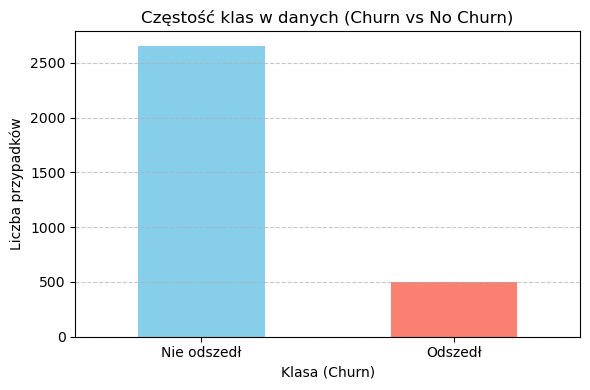

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("customer_churn_data.csv")

y = df['Churn']
fn_cost = df['FN']
fp_cost = df['FP']
X = df.drop(columns=['Churn', 'FN', 'FP'])

plt.figure(figsize=(6, 4))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Częstość klas w danych (Churn vs No Churn)")
plt.xlabel("Klasa (Churn)")
plt.ylabel("Liczba przypadków")
plt.xticks(ticks=[0, 1], labels=['Nie odszedł', 'Odszedł'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test, fn_train, fn_test, fp_train, fp_test = train_test_split(
X, y, fn_cost, fp_cost, 
test_size=0.25, stratify=y, random_state=0
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Zadanie 6 (1 punkt)**

Wytrenuj liniowy SVM:
   - ustaw maksymalnie 10000 iteracji i zbalansowane wagi klas
   - dokonaj tuningu hiperparametru `C` za pomocą 5-krotnej walidacji skrośnej
   - sprawdź 100 wartości z zakresu od $10^{-2}$ do $10^2$
   - wypisz znalezioną optymalną wartość `C`
   - wybierz model o najwyższym F1-score
   - zmierz czas treningu (włącznie z tuningiem)
   - sprawdź F1-score na zbiorze testowym
   - pamiętaj o ustawieniu `random_state=0`


In [12]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import f1_score

svm = LinearSVC(max_iter=10000, class_weight="balanced", random_state=0)

param_grid = {'C': [10**i for i in range(-2, 3)]}

start_time = time()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
end_time = time()

best_C = grid_search.best_params_['C']
best_f1 = grid_search.best_score_

training_time = end_time - start_time

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)
test_f1 = f1_score(y_test, y_pred)

print(f"Optymalna wartość C: {best_C:.4f}")
print(f"F1-score (walidacja skrośna): {best_f1:.4f}")
print(f"Czas treningu: {training_time:.2f} s")
print(f"F1-score na zbiorze testowym: {test_f1:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Optymalna wartość C: 10.0000
F1-score (walidacja skrośna): 0.6599
Czas treningu: 5.30 s
F1-score na zbiorze testowym: 0.6176


C:\Users\jakub\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**Zadanie 7 (2 punkty)**

1. Wytrenuj kernel SVM z domyślnymi hiperparametrami:
   - ustaw zbalansowane wagi klas
   - zmierz czas treningu
   - sprawdź F1-score na zbiorze testowym
   - zmierz czas treningu
   - pamiętaj o ustawieniu `random_state=0`
2. Wytrenuj kernel SVM z tuningiem hiperparametrów:
   - sprawdź kilka siatek hiperparametrów (`param_grid` może być listą słowników!)
   - dla kerneli RBF sprawdź 10 wartości `C` z zakresu od $10^{-2}$ do $10^2$, a dla `gamma` sprawdź wartość `"scale"` oraz 10 wartości z zakresu od $10^{-2}$ do $10^2$
   - dla kernela wielomianowego sprawdź 100 wartości `C` z zakresu od $10^{-2}$ do $10^2$ oraz stopnie wielomianu z zakresu [2, 5]
   - dla kernela sigmoidalnego sprawdź te same zakresy wartości, co dla RBF
3. Dokonaj analizy hiperparametrów po tuningu:
   - sprawdź, dla jakich hiperparametrów osiągnięto najwyższy wynik walidacji skrośnej
   - sprawdź, jaki był najlepszy wynik osiągnięty dla każdego z trzech kerneli
   - wypisz hiperparametry dla każdego z tych przypadków
   - który kernel wymagał najmocniejszej regularyzacji i jak sądzisz, czemu ten?
   - wytrenuj SVM dla optymalnych hiperparametrów dla każdego z trzech kerneli i sprawdź F1-score na zbiorze testowym
   - czy udało się dobrze oszacować wynik za pomocą walidacji skrośnej, tj. czy faktycznie kernel o najwyższym wyniku walidacyjnym miał najwyższy wynik testowy?


In [13]:
clf_kernel_svc_default = SVC(kernel='rbf', class_weight='balanced', random_state=0)

start_time = time()
clf_kernel_svc_default.fit(X_train_scaled, y_train)
end_time = time()
training_time_default = end_time - start_time

y_pred_default = clf_kernel_svc_default.predict(X_test_scaled)

f1_test_default = f1_score(y_test, y_pred_default)

print(f"F1-score na zbiorze testowym (domyślny kernel SVM): {f1_test_default:.4f}")
print(f"Czas treningu (domyślny kernel SVM): {training_time_default:.4f} s")


F1-score na zbiorze testowym (domyślny kernel SVM): 0.6571
Czas treningu (domyślny kernel SVM): 0.0498 s


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid_rbf = {
    'C': [10**i for i in range(-2, 3)],
    'gamma': ['scale'] + [10**i for i in range(-2, 3)]
}

param_grid_poly = {
    'C': [10**i for i in range(-2, 3)],
    'degree': [2, 5]
}

param_grid_sigmoid = {
    'C': [10**i for i in range(-2, 3)],
    'gamma': ['scale'] + [10**i for i in range(-2, 3)]
}

def tune_kernel_svm(param_grid, kernel_type):
    clf = SVC(kernel=kernel_type, class_weight='balanced', random_state=0)
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    return grid_search

grid_search_rbf = tune_kernel_svm(param_grid_rbf, kernel_type='rbf')
grid_search_poly = tune_kernel_svm(param_grid_poly, kernel_type='poly')
grid_search_sigmoid = tune_kernel_svm(param_grid_sigmoid, kernel_type='sigmoid')

best_rbf_params = grid_search_rbf.best_params_
best_poly_params = grid_search_poly.best_params_
best_sigmoid_params = grid_search_sigmoid.best_params_

best_rbf_score = grid_search_rbf.best_score_
best_poly_score = grid_search_poly.best_score_
best_sigmoid_score = grid_search_sigmoid.best_score_

print(f"Najlepsze parametry dla RBF kernel: {best_rbf_params}")
print(f"Najlepszy wynik walidacji skrośnej dla RBF kernel: {best_rbf_score:.4f}")
print(f"Najlepsze parametry dla Poly kernel: {best_poly_params}")
print(f"Najlepszy wynik walidacji skrośnej dla Poly kernel: {best_poly_score:.4f}")
print(f"Najlepsze parametry dla Sigmoid kernel: {best_sigmoid_params}")
print(f"Najlepszy wynik walidacji skrośnej dla Sigmoid kernel: {best_sigmoid_score:.4f}")

best_rbf_model = grid_search_rbf.best_estimator_
best_poly_model = grid_search_poly.best_estimator_
best_sigmoid_model = grid_search_sigmoid.best_estimator_

y_pred_rbf = best_rbf_model.predict(X_test_scaled)
y_pred_poly = best_poly_model.predict(X_test_scaled)
y_pred_sigmoid = best_sigmoid_model.predict(X_test_scaled)

f1_rbf = f1_score(y_test, y_pred_rbf)
f1_poly = f1_score(y_test, y_pred_poly)
f1_sigmoid = f1_score(y_test, y_pred_sigmoid)

print(f"F1-score na zbiorze testowym dla RBF kernel: {f1_rbf:.4f}")
print(f"F1-score na zbiorze testowym dla Poly kernel: {f1_poly:.4f}")
print(f"F1-score na zbiorze testowym dla Sigmoid kernel: {f1_sigmoid:.4f}")


Najlepsze parametry dla RBF kernel: {'C': 10, 'gamma': 1}
Najlepszy wynik walidacji skrośnej dla RBF kernel: 0.8518
Najlepsze parametry dla Poly kernel: {'C': 100, 'degree': 5}
Najlepszy wynik walidacji skrośnej dla Poly kernel: 0.8279
Najlepsze parametry dla Sigmoid kernel: {'C': 0.1, 'gamma': 0.01}
Najlepszy wynik walidacji skrośnej dla Sigmoid kernel: 0.6587
F1-score na zbiorze testowym dla RBF kernel: 0.8506
F1-score na zbiorze testowym dla Poly kernel: 0.8346
F1-score na zbiorze testowym dla Sigmoid kernel: 0.6000


Walidacja skrośna dobrze oszacowała wyniki dla kerneli RBF i Poly, gdzie F1-score na zbiorze testowym był zbliżony do wyniku walidacji. Natomiast kernel sigmoidalny, mimo przyzwoitego wyniku walidacji, miał gorszy wynik na zbiorze testowym, co sugeruje, że nie radził sobie najlepiej z danymi.

Nie uwzględniliśmy jednak jeszcze faktu, że nasi klienci mają różną wagę. Według badań koszt zyskania klienta jest około 15 razy wyższy od kosztu utrzymania klienta, który jest zagrożony przejściem dla konkurencji. W związku z tym FP i FN mają różną ważnośc. Dodatkowo sami klienci płacą mniej lub więcej, więc to też trzeba uwzględnić. Na szczęście my mamy już to zrobione, bo mamy macierze `fp_cost` oraz `fn_cost` oznaczające koszt pomylenia się na oba sposoby w przypadku każdego klienta.

Powinniśmy zatem używać **ważonej metryki (weighted metric)**, która dla każdego przykładu stosuje odpowiednią wagę, i to w zależności od tego, w jaki sposób się pomyliliśmy. Tego typu metryki typowo działają jak funkcje kosztu - im mniejsza wartość, tym lepiej, bo często dosłownie reprezentują koszt, jaki firma musi ponieść przy stosowaniu danego algorytmu. Wykorzystanie takiej metryki to **cost-sensitive classification**.

**Zadanie 8 (0.5 punktu)**

1. Uzupełnij kod funkcji `churn_cost()`, która oblicza koszt dokonania danej klasyfikacji.
2. Stwórz funkcję w postaci akceptowanej przez `GridSearchCV` za pomocą `make_scorer`. Zwróć uwagę, żeby podać do niej prawidłowe argumenty.

In [33]:
from typing import Union
import numpy as np
from sklearn.metrics import make_scorer

def churn_cost(
    y_true: Union[np.ndarray, pd.Series],
    y_pred: Union[np.ndarray, pd.Series],
    fp_cost: Union[np.ndarray, pd.Series],
    fn_cost: Union[np.ndarray, pd.Series],
) -> float:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fp_cost = np.array(fp_cost)
    fn_cost = np.array(fn_cost)
    
    fp_mask = (y_pred == 1) & (y_true == 0)
    fn_mask = (y_pred == 0) & (y_true == 1)

    fp_total_cost = np.sum(fp_cost[fp_mask]) 
    fn_total_cost = np.sum(fn_cost[fn_mask])

    total_cost = fp_total_cost + fn_total_cost
    return total_cost
fp_cost_test = fp_cost[:len(y_test)]
fn_cost_test = fn_cost[:len(y_test)]
churn_cost_score = make_scorer(churn_cost, greater_is_better=False)


**Zadanie 9 (1 punkt)**

1. Wytrenuj klasyfikatory stały `DummyClassifier`:
   - taki, który zawsze przewiduje klasę negatywną (brak zmiany)
   - taki, który zawsze przewiduje klasę pozytywną (churn)
2. Sprawdź metrykę F1-score oraz nasz nowo zdefiniowany churn cost dla takich rozwiązań na zbiorze testowym. Wykorzystaj `fp_cost_test` oraz `fn_cost_test`.
3. Lepiej jest stosować reklamy dla wszystkich, czy po prostu zgodzić się na churn i nic z tym nie robić? Uwzględniając liczbę próbek w zbiorze testowym, czy twoim zdaniem wysoki koszt? Załóż, że walutą są dolary - irański rial zawsze był tak słabą walutą, że i tak używano walut zagranicznych, co widać też w tym zbiorze. Wartość każdego klienta jest typowo wysoka, bo to obliczona tzw. lifetime value - przewidywana potencjalna wartość klienta w przyszłości.

In [34]:
from sklearn.dummy import DummyClassifier
dummy_negative = DummyClassifier(strategy='constant', constant=0, random_state=0)
dummy_positive = DummyClassifier(strategy='constant', constant=1, random_state=0)

dummy_negative.fit(X_train_scaled, y_train)
dummy_positive.fit(X_train_scaled, y_train)

y_pred_negative = dummy_negative.predict(X_test_scaled)
y_pred_positive = dummy_positive.predict(X_test_scaled)

f1_negative = f1_score(y_test, y_pred_negative)
f1_positive = f1_score(y_test, y_pred_positive)


churn_cost_negative = churn_cost(y_test, y_pred_negative, fp_cost_test, fn_cost_test)
churn_cost_positive = churn_cost(y_test, y_pred_positive, fp_cost_test, fn_cost_test)

print(f"Dummy Classifier (Negative Class) - F1-score: {f1_negative:.4f}")
print(f"Dummy Classifier (Negative Class) - Churn Cost: {churn_cost_negative:.4f}")

print(f"Dummy Classifier (Positive Class) - F1-score: {f1_positive:.4f}")
print(f"Dummy Classifier (Positive Class) - Churn Cost: {churn_cost_positive:.4f}")

Dummy Classifier (Negative Class) - F1-score: 0.0000
Dummy Classifier (Negative Class) - Churn Cost: 52738.6635
Dummy Classifier (Positive Class) - F1-score: 0.2719
Dummy Classifier (Positive Class) - Churn Cost: 65804.3990


lepiej jest stosować reklamy dla wszystkich, ponieważ choć F1-score dla tego modelu jest niski, churn cost jest niższy niż w przypadku przewidywania klasy negatywnej.

**Zadanie 10 (1.5 punktu)**

1. Wytrenuj liniowy SVM, wykorzystaj znalezioną wcześniej optymalną wartość `C`. Innych parametrów użyj tak, jak wcześniej. Jaki jest koszt przy wdrożeniu takiego rozwiązania? Ile zyskujemy względem najlepszego rozwiązania z poprzedniego zadania?
2. Wytrenuj kernel SVM, wykorzystaj znalezione wcześniej optymalne wartości hiperparametrów. Innych parametrów użyj tak, jak wcześniej. O ile lepszy jest koszt? O ile lepszy jest od modelu liniowego, jakim jest liniowy SVM?
3. Czy twoim zdaniem warto wdrażać rozwiązania oparte o ML do takich zadań?

In [39]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import time

optimal_C = 10

start_time = time.time()
linear_svm = SVC(kernel='linear', C=optimal_C, class_weight='balanced', random_state=0)
linear_svm.fit(X_train_scaled, y_train)
linear_svm_training_time = time.time() - start_time
y_pred_linear = linear_svm.predict(X_test_scaled)

f1_linear = f1_score(y_test, y_pred_linear)
churn_cost_linear = churn_cost(y_test, y_pred_linear, fp_cost_test, fn_cost_test)

print(f"Liniowy SVM - F1-score: {f1_linear:.4f}")
print(f"Liniowy SVM - Churn Cost: {churn_cost_linear:.4f}")
print(f"Czas treningu liniowego SVM: {linear_svm_training_time:.4f} s")

optimal_C_rbf = 10  
optimal_gamma = 1  

start_time = time.time()
rbf_svm = SVC(kernel='rbf', C=optimal_C_rbf, gamma=optimal_gamma, class_weight='balanced', random_state=0)
rbf_svm.fit(X_train_scaled, y_train)
rbf_svm_training_time = time.time() - start_time

y_pred_rbf = rbf_svm.predict(X_test_scaled)
f1_rbf = f1_score(y_test, y_pred_rbf)
churn_cost_rbf = churn_cost(y_test, y_pred_rbf, fp_cost_test, fn_cost_test)

print(f"RBF SVM - F1-score: {f1_rbf:.4f}")
print(f"RBF SVM - Churn Cost: {churn_cost_rbf:.4f}")
print(f"Czas treningu RBF SVM: {rbf_svm_training_time:.4f} s")

cost_difference = churn_cost_linear - churn_cost_rbf
f1_difference = f1_rbf - f1_linear

print(f"Różnica kosztu (Liniowy SVM vs RBF SVM): {cost_difference:.4f}")
print(f"Różnica F1-score (Liniowy SVM vs RBF SVM): {f1_difference:.4f}")


Liniowy SVM - F1-score: 0.5913
Liniowy SVM - Churn Cost: 20785.4150
Czas treningu liniowego SVM: 0.1360 s
RBF SVM - F1-score: 0.8506
RBF SVM - Churn Cost: 7958.0335
Czas treningu RBF SVM: 0.0689 s
Różnica kosztu (Liniowy SVM vs RBF SVM): 12827.3815
Różnica F1-score (Liniowy SVM vs RBF SVM): 0.2593


Wyniki pokazują, że model RBF SVM daje znacznie lepsze wyniki niż liniowy SVM. RBF SVM osiągnął wyższy F1-score i znacznie niższy churn. Dodatkowo czas treningu RBF SVM był krótszy.

## Zadanie dodatkowe (3 punkty)

W przypadku, kiedy zastosowanie kernel SVM wprost byłoby zbyt kosztowne, można zamiast tego przybliżyć cechy kernelowe. Realizują to algorytmy grupy kernel approximation.

Metoda Nyströma to algorytm uniwersalny, który potrafi przybliżyć dowolny kernel. Wykorzystuje do tego truncated SVD, czyli przybliża wprost kernel matrix za pomocą macierzy niższej rangi. Ceną tej prostoty i uniwersalności jest nie najlepsza prędkość działania w porównaniu do bardziej specjalistycznych algorytmów. Proste wyprowadzenie tej metody można znaleźć [tutaj](https://stats.stackexchange.com/questions/261149/nystroem-method-for-kernel-approximation).

`RBFSampler` w Scikit-learn implementuje metodę Random Kitchen Sinks. Ten algorytm za pomocą próbkowania Monte Carlo przybliża coraz lepiej macierz kernela RBF. W bibliotece Scikit-learn-extra zaimplementowane jest rozwinięcie tego algorytmu o nazwie [Fastfood](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.kernel_approximation.Fastfood.html), który stosuje nieco bardziej zaawansowany algorytm przybliżający, który powinien być jeszcze szybszy i oszczędniejszy pamięciowo.

Hiperparametry tych metod są podobne do zwykłego kernel SVM, ale dodatkowo mamy wymiarowość naszego przybliżenia, czyli `n_components`. Im większe, tym dokładniej przybliżamy, ale też tym więcej mamy cech. Wejściem do metody Nyströma jest macierz cech X, a wyjściem macierz cech kernelowych X mająca rozmiar `n_samples * n_components`. Na takich cechach trenuje się już zwykły liniowy SVM.

1. Zaimplementuj `Pipeline` składający się z przybliżenia kernela oraz liniowego SVM: dla metody Nyströma, oraz dla obu algorytmów dla kernela RBF.
2. Wytrenuj algorytmy z domyślnymi hiperparametrami dla zbioru Cod-RNA. Porównaj jakość predykcji oraz szybkość z liniowym SVM i kernel SVM. Czy warto wykorzystać takie podejście?
3. Dokonaj optymalizacji hiperparametrów `C`, `gamma` oraz `n_components`. Czy udało się poprawić wynik względem zwykłego kernel SVM w rozsądnym czasie?

// skomentuj tutaj